In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl





In [2]:
# 1. CARICAMENTO E PULIZIA DATI
df = pd.read_excel('TimeSeries/Dataset-Project-Deep-Learning-SMRES-Unificato.xlsx')

In [3]:
df.describe()

,Data,Potenza Uffici [W],Temperatura [K],Nuvolosità [%],Irraggiamento [kWh/m2]
count,13104,13104.000000,13104.000000,13104.000000,13104.000000
mean,2021-09-30 11:59:59.999999744,69626.025946,289.407343,18.189408,0.192876
min,2021-01-01 00:00:00,12096.000000,272.850000,0.000000,0.000000
25%,2021-05-17 00:00:00,57624.000000,283.760000,0.000000,0.000000
50%,2021-09-30 12:00:00,66864.000000,288.150000,0.000000,0.012570
75%,2022-02-14 00:00:00,81648.000000,295.180000,40.000000,0.345670
max,2022-06-30 00:00:00,135324.000000,312.860000,100.000000,0.973580
std,NaN,18791.840099,7.443362,26.242815,0.272301


In [4]:
# 1. Conversione della colonna Data in formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y %H:%M:%S')

# 2. Estrazione dell'ora dalla colonna Ora (ad esempio "14:00" -> 14)
df['Ora'] = df['Ora'].str.split(':').str[0].astype(int)

# 3. Calcolo delle trasformazioni orarie
df['Day_sin'] = np.sin(2 * np.pi * df['Ora'] / 24)
df['Day_cos'] = np.cos(2 * np.pi * df['Ora'] / 24)

# 4. Costruzione della colonna date_time combinando la data (senza orario) e l'ora
df['date_time'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

# 5. Calcolo del timestamp in secondi dalla colonna date_time
timestamp_s = df['date_time'].map(pd.Timestamp.timestamp)

In [5]:
df['Data'].max()

Timestamp('2022-06-30 00:00:00')

In [6]:
data = df[['Potenza Uffici [W]','Temperatura [K]','Nuvolosità [%]','Irraggiamento [kWh/m2]','Day_sin','Day_cos']]

**vai alla cella 33**

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13104 entries, 0 to 13103
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Potenza Uffici [W]      13104 non-null  int64  
 1   Temperatura [K]         13104 non-null  float64
 2   Nuvolosità [%]          13104 non-null  int64  
 3   Irraggiamento [kWh/m2]  13104 non-null  float64
 4   Day_sin                 13104 non-null  float64
 5   Day_cos                 13104 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 614.4 KB


Text(0.5, 1.0, 'Time of day signal')

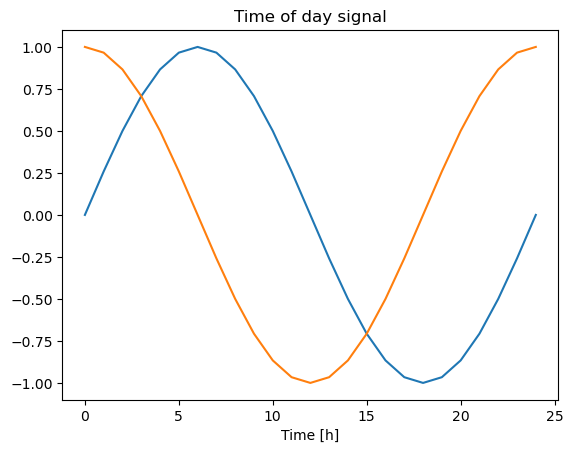

In [8]:
plt.plot(np.array(data['Day_sin'])[:25])
plt.plot(np.array(data['Day_cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

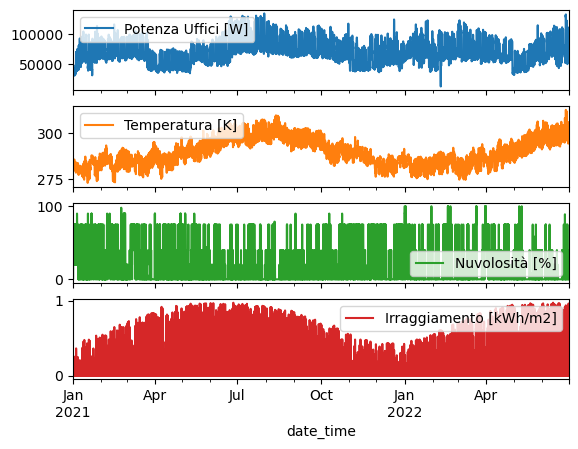

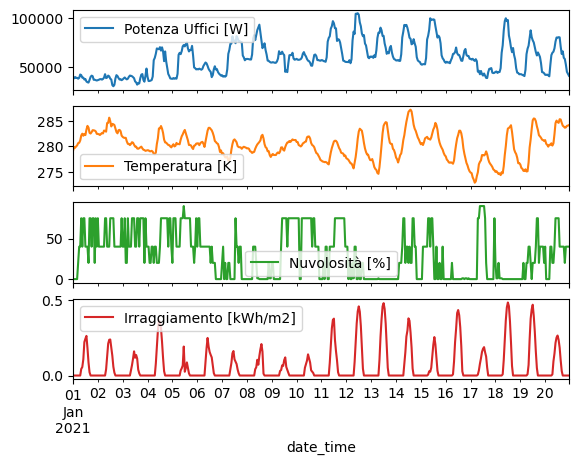

In [9]:
df['date_time'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

df.set_index('date_time', inplace=True)
plot_cols = ['Potenza Uffici [W]', 'Temperatura [K]', 'Nuvolosità [%]', 'Irraggiamento [kWh/m2]']

plot_features = df[plot_cols]
plot_features = df[plot_cols]  # Seleziona solo le colonne da plottare
_ = plot_features.plot(subplots=True)  # Plotta direttamente con l'indice già corretto

plot_features = df[plot_cols].iloc[:480]  # Seleziona le prime 480 righe
_ = plot_features.plot(subplots=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13104 entries, 0 to 13103
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Potenza Uffici [W]      13104 non-null  int64  
 1   Temperatura [K]         13104 non-null  float64
 2   Nuvolosità [%]          13104 non-null  int64  
 3   Irraggiamento [kWh/m2]  13104 non-null  float64
 4   Day_sin                 13104 non-null  float64
 5   Day_cos                 13104 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 614.4 KB


**VEDI DA QUI** +


In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

# Supponiamo di avere un DataFrame 'data'
# 1. Suddivisione e standardizzazione dei dati
n = len(data)
train_data = data.iloc[:int(n*0.7)]
val_data   = data.iloc[int(n*0.7):int(n*0.9)]
test_data  = data.iloc[int(n*0.9):]

train_mean = train_data.mean()
train_std  = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data   = (val_data - train_mean) / train_std
test_data  = (test_data - train_mean) / train_std

# 2. Definizione dei parametri di windowing per la predizione sequence-to-sequence
input_width = 12   # lunghezza della sequenza di input (es. 24 ore)
label_width = 12   # lunghezza della sequenza target (predizione per le prossime 24 ore)
shift       = 12   # gap fra input e target (in questo caso, non c'è gap, basta che la finestra target sia alla fine)

total_window_size = input_width + shift  # lunghezza totale della finestra
''' 
# 3. Funzione per creare un tf.data.Dataset con batching
def make_dataset(data, input_width, label_width, shift, batch_size):
    data_array = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data_array,
        targets=None,
        sequence_length=total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size
    )
    
    # Funzione per dividere la finestra in input e target
    def split_window(window):
        inputs = window[:, :input_width, :]
        labels = window[:, -label_width:, :]
        return inputs, labels
    
    ds = ds.map(split_window)
    return ds
'''
def make_dataset(data, input_width, label_width, shift, batch_size, target_col="Potenza Uffici [W]"):
    # Converte il DataFrame in array numpy
    data_array = np.array(data, dtype=np.float32)
    total_window_size = input_width + shift
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data_array,
        targets=None,
        sequence_length=total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size
    )
    # Ottieni l'indice della colonna target
    target_col_index = data.columns.get_loc(target_col)
    
    def split_window(window):
        inputs = window[:, :input_width, :]
        # Seleziona solo la colonna target per le etichette:
        labels = window[:, input_width:input_width+label_width, target_col_index]
        # labels avrà forma (batch, label_width)
        return inputs, labels
    
    ds = ds.map(split_window)
    return ds
# Creiamo i dataset con un batch size placeholder (sarà sostituito dalla grid search nel training finale)
placeholder_batch_size = 32
train_ds = make_dataset(train_data, input_width, label_width, shift, placeholder_batch_size)
val_ds   = make_dataset(val_data, input_width, label_width, shift, placeholder_batch_size)
test_ds  = make_dataset(test_data, input_width, label_width, shift, placeholder_batch_size)

# Creiamo le sequenze specificando il target (ad es. "Potenza Uffici [W]")
def create_sequences_df(df, input_width=24, out_steps=24, target_col="Potenza Uffici [W]"):
    sequences = []
    labels = []
    for i in range(len(df) - input_width - out_steps + 1):
        seq_input = df.iloc[i : i + input_width].values
        # Selezioniamo solo la colonna target
        seq_label = df.iloc[i + input_width : i + input_width + out_steps][target_col].values
        sequences.append(seq_input)
        labels.append(seq_label)
    sequences = np.array(sequences)
    labels = np.array(labels)
    # Per out_steps > 1 manteniamo la shape (N, out_steps)
    return sequences, labels

# Creazione delle sequenze per la grid search
X_train, y_train = create_sequences_df(train_data, input_width=24, out_steps=24, target_col="Potenza Uffici [W]")
X_val,   y_val   = create_sequences_df(val_data,   input_width=24, out_steps=24, target_col="Potenza Uffici [W]")


X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

# Definiamo gli indici
train_size = len(X_train)
val_size   = len(X_val)

train_indices = np.arange(0, len(X_train))
val_indices   = np.arange(len(X_train), len(X_train) + len(X_val))
custom_cv = [(train_indices, val_indices)]

# Il modello, nel build_model, ha un output di 24 unità, quindi ora y_trainval ha shape (n_samples, 24)
def build_model(lstm_units=64, dense_units=24, dropout_rate=0.0, learning_rate=0.001, **kwargs):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(24, train_data.shape[1])),  # train_data.shape[1] indica il numero di feature
        tf.keras.layers.LSTM(lstm_units, dropout=dropout_rate),
        tf.keras.layers.Dense(dense_units)
    ])
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model





In [12]:
y_trainval.shape

(11699, 24)

In [13]:
X_trainval.shape

(11699, 24, 6)

In [14]:
# 5. Costruzione del modello (la struttura non dipende dal batch size)
def build_model(lstm_units=64, dense_units=24, dropout_rate=0.0, learning_rate=0.001, **kwargs):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_width, train_data.shape[-1])),
        tf.keras.layers.LSTM(lstm_units, dropout=dropout_rate),
        # Qui Dense restituisce un output "flattened"; per sequence-to-sequence si potrebbe usare un layer TimeDistributed
        tf.keras.layers.Dense(dense_units)
    ])
    
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

# Wrapping per l'uso con GridSearchCV
model_wrapper = KerasRegressor(model=build_model, verbose=0, flatten=False)

# 6. Definizione della grid search sugli iperparametri, compreso il batch_size
param_grid = {
    "model__lstm_units": [32, 64, 128],
    "model__dropout_rate": [0.0, 0.2],
    "model__learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32, 64],
    "epochs": [100]  
}

grid_search = GridSearchCV(
    estimator=model_wrapper,
    param_grid=param_grid,
    cv=custom_cv,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_trainval, y_trainval)
print("Migliori iperparametri:", grid_search.best_params_)
print("Miglior punteggio:", grid_search.best_score_)

best_params = grid_search.best_params_


Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] END batch_size=32, epochs=100, model__dropout_rate=0.0, model__learning_rate=0.001, model__lstm_units=32; total time= 1.7min
[CV] END batch_size=32, epochs=100, model__dropout_rate=0.0, model__learning_rate=0.001, model__lstm_units=64; total time= 2.1min
[CV] END batch_size=16, epochs=100, model__dropout_rate=0.0, model__learning_rate=0.001, model__lstm_units=32; total time= 3.1min
[CV] END batch_size=16, epochs=100, model__dropout_rate=0.2, model__learning_rate=0.001, model__lstm_units=32; total time= 3.1min
[CV] END batch_size=16, epochs=100, model__dropout_rate=0.2, model__learning_rate=0.0005, model__lstm_units=32; total time= 3.1min
[CV] END batch_size=16, epochs=100, model__dropout_rate=0.0, model__learning_rate=0.0005, model__lstm_units=32; total time= 3.2min
[CV] END batch_size=16, epochs=100, model__dropout_rate=0.0, model__learning_rate=0.0005, model__lstm_units=64; total time= 3.6min
[CV] END batch_size=16, ep

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# 7. Costruzione del modello finale con i migliori iperparametri
final_model = build_model(
    lstm_units=best_params["model__lstm_units"],
    dropout_rate=best_params["model__dropout_rate"],
    learning_rate=best_params["model__learning_rate"],
    dense_units=12  # questo parametro può essere ulteriormente regolato se necessario
)

# Ricreiamo i dataset TF con il batch size ottimale dalla grid search
train_ds = make_dataset(train_data, input_width, label_width, shift, best_params["batch_size"])
val_ds   = make_dataset(val_data, input_width, label_width, shift, best_params["batch_size"])
test_ds  = make_dataset(test_data, input_width, label_width, shift, best_params["batch_size"])

# 8. Addestramento del modello finale
final_model.fit(
    train_ds,
    epochs=best_params["epochs"],
    validation_data=val_ds,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss, test_mae = final_model.evaluate(test_ds, verbose=1)
print("\n\n Test loss:", test_loss, "Test MAE:", test_mae)

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8788 - mean_absolute_error: 0.7383 - val_loss: 0.4463 - val_mean_absolute_error: 0.5008
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4505 - mean_absolute_error: 0.5258 - val_loss: 0.3629 - val_mean_absolute_error: 0.4595
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3802 - mean_absolute_error: 0.4788 - val_loss: 0.3391 - val_mean_absolute_error: 0.4434
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3601 - mean_absolute_error: 0.4638 - val_loss: 0.3205 - val_mean_absolute_error: 0.4311
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3454 - mean_absolute_error: 0.4529 - val_loss: 0.3152 - val_mean_absolute_error: 0.4287
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3442 - mean_absolute_error: 0.4489 - val_loss: 0.3080 - val_mean_absolute_error: 0.4232
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3288 - mean_absolute_error: 0.4

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(inputs, labels, predictions, target_index, max_subplots=5):
    """
    inputs: array numpy di shape (num_samples, input_width, num_features)
    labels: array numpy di shape (num_samples, label_width) oppure (num_samples, label_width, num_features)
    predictions: array numpy di shape (num_samples, label_width) oppure (num_samples, label_width, num_features)
    target_index: indice della colonna target (per inputs e, se presente, per labels/predictions a 3D)
    max_subplots: numero massimo di subplot da mostrare
    """
    num_samples = min(max_subplots, inputs.shape[0])
    input_width = inputs.shape[1]
    # Assumiamo che il label_width sia la seconda dimensione di labels (se 2D)
    label_width = labels.shape[1] if labels.ndim == 2 else labels.shape[1]
    
    plt.figure(figsize=(12, num_samples * 3))
    
    for n in range(num_samples):
        plt.subplot(num_samples, 1, n + 1)
        
        # Time axis per gli input: 0 ... input_width-1
        x_input = np.arange(input_width)
        plt.plot(x_input,
                 inputs[n, :, target_index],
                 label="Input", marker=".", linestyle="-")
        
        # Time axis per le label e le previsioni: input_width ... input_width+label_width-1
        x_future = np.arange(input_width, input_width + label_width)
        
        # Estrae le label: se labels è 3D, prendi la colonna target; se è 2D usala direttamente
        if labels.ndim == 3:
            label_values = labels[n, :, target_index]
        else:
            label_values = labels[n, :]
        
        plt.scatter(x_future,
                    label_values,
                    label="Label", color="green", s=64)
        
        # Estrae le previsioni in modo simile
        if predictions.ndim == 3:
            pred_values = predictions[n, :, target_index]
        else:
            pred_values = predictions[n, :]
        
        plt.scatter(x_future,
                    pred_values,
                    label="Prediction", marker="x", color="red",
                    s=64)
        
        if n == 0:
            plt.legend()
        plt.xlabel("Time step")
    
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


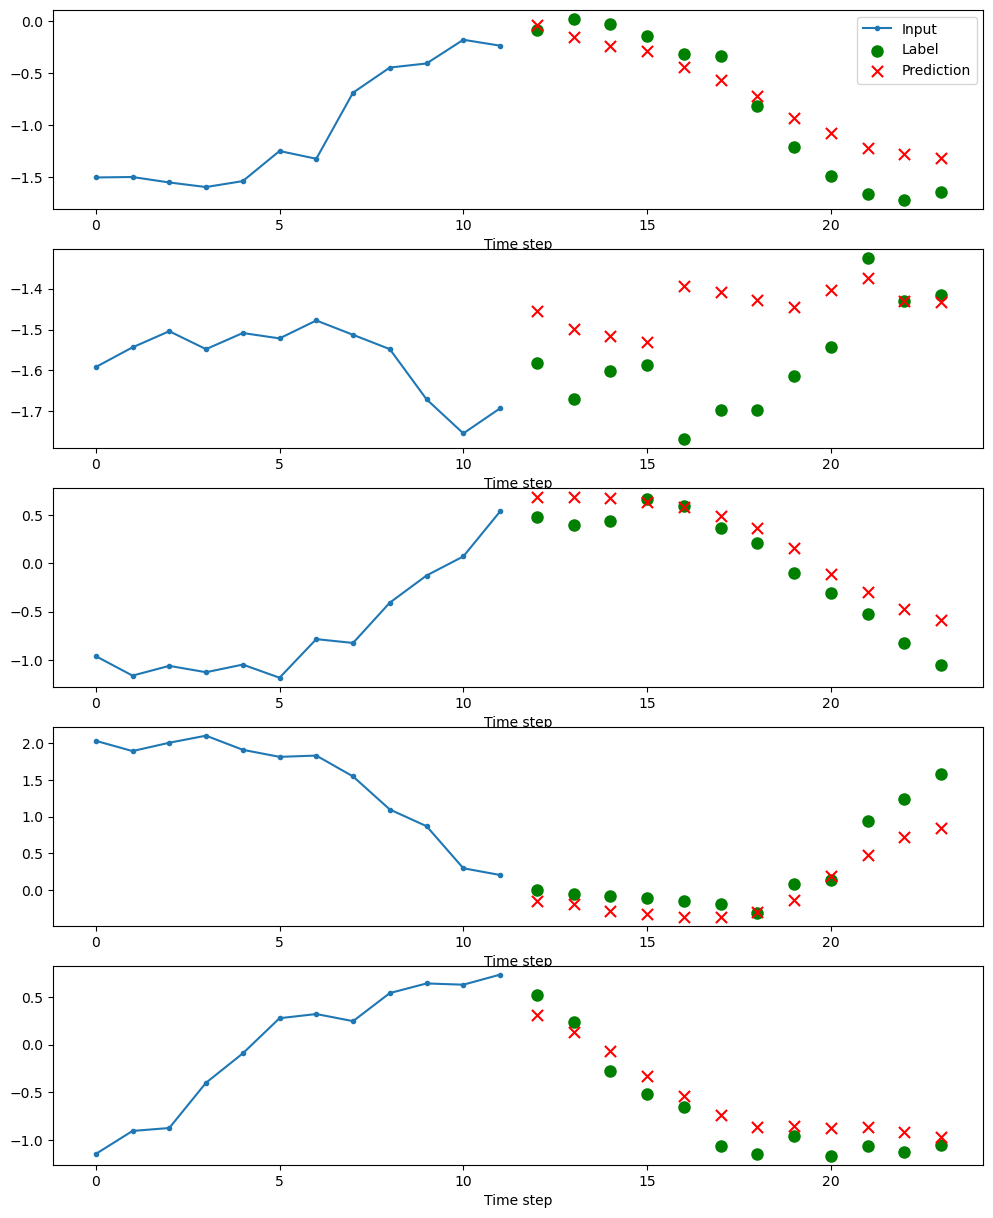

In [18]:
for test_inputs, test_labels in test_ds.take(1):
    test_predictions = final_model.predict(test_inputs)
    break

target_col = "Potenza Uffici [W]"
target_index = data.columns.get_loc(target_col)

plot_predictions(test_inputs.numpy(), test_labels.numpy(), test_predictions, target_index, max_subplots=5)

In [23]:
n_iterations = 120  # 60 iterazioni * 24 step = 1440 ore

# Otteniamo l'ultimo window di input conosciuto (input_width = 24)
last_window = data.iloc[-input_width:].values  # shape: (24, num_features)

current_window = last_window.copy()
future_predictions = []

target_col = "Potenza Uffici [W]"
target_index = data.columns.get_loc(target_col)

for i in range(n_iterations):
    pred = final_model.predict(np.expand_dims(current_window, axis=0))  # shape: (1, 24)
    pred = pred[0]  # forma: (24,)
    
    future_predictions.append(pred)
    
    # Crea nuove righe con i valori predetti
    new_rows = np.repeat(current_window[-1:], 12, axis=0)  # forma: (24, num_features)
    new_rows[:, target_index] = pred  # sostituisce il target con i valori predetti
    
    # Aggiorna la finestra: aggiungi le nuove righe e prendi le ultime 24 righe
    current_window = np.concatenate([current_window, new_rows], axis=0)[-input_width:]
    
# Unisci le predizioni in un array singolo: (60 * 24 = 1440,)
future_predictions = np.concatenate(future_predictions, axis=0)

print("Predizioni future (1440 step):", future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

**IRRAGIAMENTO**

In [24]:
# Creazione delle sequenze per la grid search
X_train, y_train = create_sequences_df(train_data, input_width=24, out_steps=24, target_col="Irraggiamento [kWh/m2]")
X_val,   y_val   = create_sequences_df(val_data,   input_width=24, out_steps=24, target_col="Irraggiamento [kWh/m2]")


X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

# Definiamo gli indici
train_size = len(X_train)
val_size   = len(X_val)

train_indices = np.arange(0, len(X_train))
val_indices   = np.arange(len(X_train), len(X_train) + len(X_val))
custom_cv = [(train_indices, val_indices)]

# Il modello, nel build_model, ha un output di 24 unità, quindi ora y_trainval ha shape (n_samples, 24)
def build_model(lstm_units=64, dense_units=24, dropout_rate=0.0, learning_rate=0.001, **kwargs):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(24, train_data.shape[1])),  # train_data.shape[1] indica il numero di feature
        tf.keras.layers.LSTM(lstm_units, dropout=dropout_rate),
        tf.keras.layers.Dense(dense_units)
    ])
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

In [25]:
# 5. Costruzione del modello (la struttura non dipende dal batch size)
def build_model(lstm_units=64, dense_units=24, dropout_rate=0.0, learning_rate=0.001, **kwargs):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_width, train_data.shape[-1])),
        tf.keras.layers.LSTM(lstm_units, dropout=dropout_rate),
        # Qui Dense restituisce un output "flattened"; per sequence-to-sequence si potrebbe usare un layer TimeDistributed
        tf.keras.layers.Dense(dense_units)
    ])
    
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

# Wrapping per l'uso con GridSearchCV
model_wrapper = KerasRegressor(model=build_model, verbose=0, flatten=False)

# 6. Definizione della grid search sugli iperparametri, compreso il batch_size
param_grid = {
    "model__lstm_units": [32, 64, 128],
    "model__dropout_rate": [0.0, 0.2],
    "model__learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32, 64],
    "epochs": [100]  
}

grid_search = GridSearchCV(
    estimator=model_wrapper,
    param_grid=param_grid,
    cv=custom_cv,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_trainval, y_trainval)
print("Migliori iperparametri:", grid_search.best_params_)
print("Miglior punteggio:", grid_search.best_score_)

best_params = grid_search.best_params_


Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] END batch_size=32, epochs=100, model__dropout_rate=0.0, model__learning_rate=0.001, model__lstm_units=32; total time= 1.6min
[CV] END batch_size=32, epochs=100, model__dropout_rate=0.0, model__learning_rate=0.001, model__lstm_units=64; total time= 2.1min
[CV] END batch_size=16, epochs=100, model__dropout_rate=0.2, model__learning_rate=0.0005, model__lstm_units=32; total time= 2.9min
[CV] END batch_size=16, epochs=100, model__dropout_rate=0.0, model__learning_rate=0.0005, model__lstm_units=32; total time= 2.9min
[CV] END batch_size=16, epochs=100, model__dropout_rate=0.2, model__learning_rate=0.001, model__lstm_units=32; total time= 3.0min
[CV] END batch_size=16, epochs=100, model__dropout_rate=0.0, model__learning_rate=0.001, model__lstm_units=32; total time= 3.0min
[CV] END batch_size=16, epochs=100, model__dropout_rate=0.0, model__learning_rate=0.0005, model__lstm_units=64; total time= 3.5min
[CV] END batch_size=16, ep

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# 7. Costruzione del modello finale con i migliori iperparametri
final_model = build_model(
    lstm_units=best_params["model__lstm_units"],
    dropout_rate=best_params["model__dropout_rate"],
    learning_rate=best_params["model__learning_rate"],
    dense_units=12  # questo parametro può essere ulteriormente regolato se necessario
)

# Ricreiamo i dataset TF con il batch size ottimale dalla grid search
train_ds = make_dataset(train_data, input_width, label_width, shift, best_params["batch_size"])
val_ds   = make_dataset(val_data, input_width, label_width, shift, best_params["batch_size"])
test_ds  = make_dataset(test_data, input_width, label_width, shift, best_params["batch_size"])

# 8. Addestramento del modello finale
final_model.fit(
    train_ds,
    epochs=best_params["epochs"],
    validation_data=val_ds,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss, test_mae = final_model.evaluate(test_ds, verbose=1)
print("\n\n Test loss:", test_loss, "Test MAE:", test_mae)

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7707 - mean_absolute_error: 0.6898 - val_loss: 0.3801 - val_mean_absolute_error: 0.4684
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4026 - mean_absolute_error: 0.4935 - val_loss: 0.3531 - val_mean_absolute_error: 0.4552
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3679 - mean_absolute_error: 0.4655 - val_loss: 0.3268 - val_mean_absolute_error: 0.4376
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3518 - mean_absolute_error: 0.4521 - val_loss: 0.3186 - val_mean_absolute_error: 0.4314
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3409 - mean_absolute_error: 0.4447 - val_loss: 0.3112 - val_mean_absolute_error: 0.4261
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3309 - mean_absolute_error: 0.4351 - val_loss: 0.2935 - val_mean_absolute_error: 0.4137
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3215 - mean_absolute_error: 0.4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


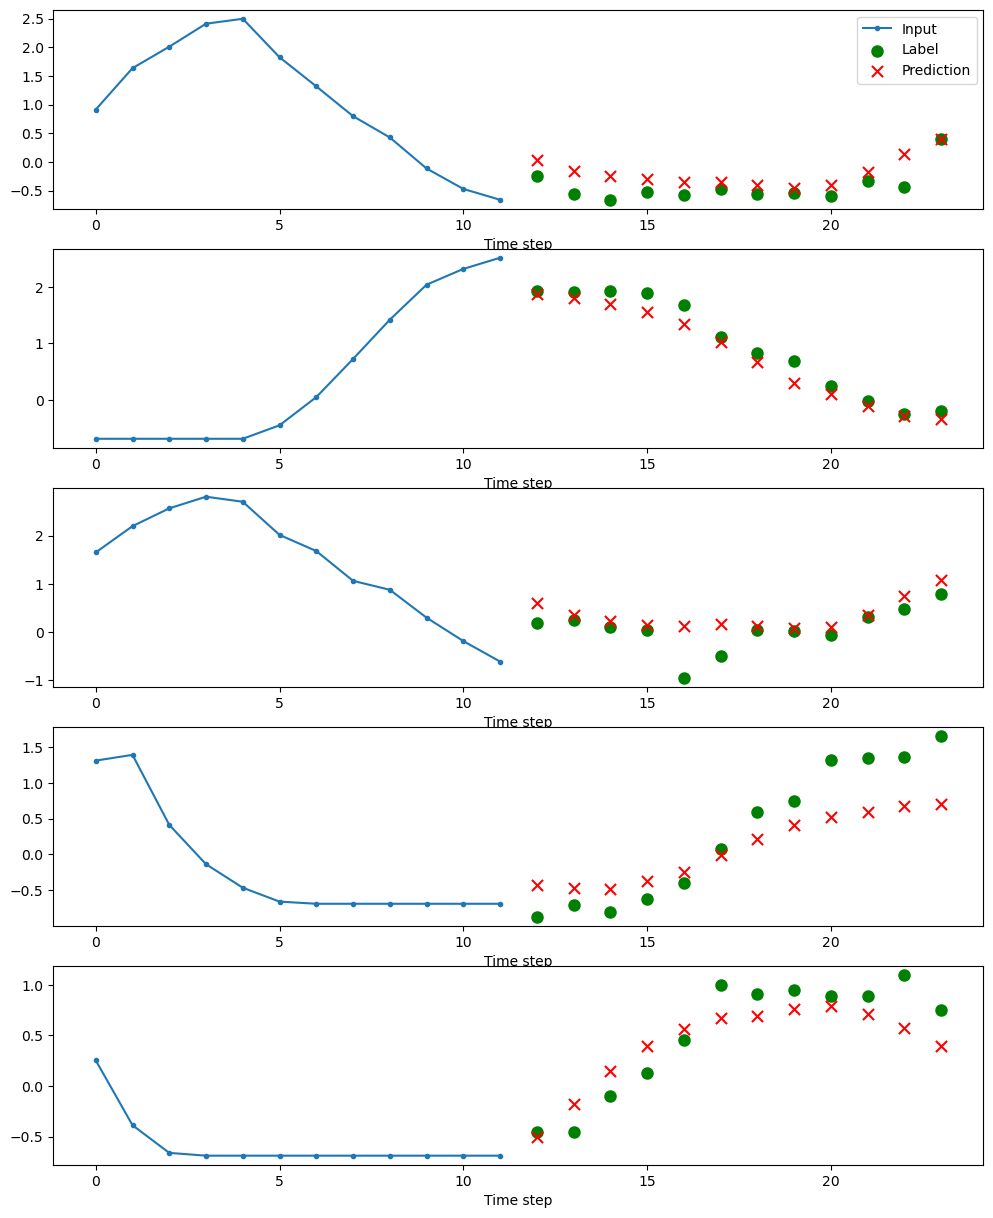

In [27]:
for test_inputs, test_labels in test_ds.take(1):
    test_predictions = final_model.predict(test_inputs)
    break

target_col = "Irraggiamento [kWh/m2]"
target_index = data.columns.get_loc(target_col)

plot_predictions(test_inputs.numpy(), test_labels.numpy(), test_predictions, target_index, max_subplots=5)